In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

            
# Function to perform d-choice allocation            
def d_choice(bins, bins_info, n, **kwargs):
    assert 'd' in kwargs.keys()
    d = kwargs.get('d')
    m = len(bins)

    # We compute the randomness before to take profit of numpy parallel speed
    if d == 1:
        choices = np.random.randint(low=0, high=m, size=n)
        for k in range(n):
            bins[choices[k]] += 1
    elif d == 2: # Specialized code for performance
        choices = np.random.randint(low=0, high=m, size=(n,2))
        tiebreak = np.random.rand(n)
        for k in range(n):
            i, j = choices[k]
            if bins_info[i] < bins_info[j]:
                bins[i] += 1
            elif bins_info[j] < bins_info[i]:
                bins[j] += 1
            else:
                if tiebreak[k] < 0.5:
                    bins[i] += 1
                else:
                    bins[j] += 1
    else: # General d-choice
        choices = np.random.randint(low=0, high=m, size=(n,d))
        tiebreak = np.random.rand(n)
        for k in range(n):
            minim = np.min(bins_info[choices[k]])
            minim_indices = np.where(bins_info[choices[k]] == minim)[0]
            candidates = choices[k][minim_indices]
            selected = candidates[int(tiebreak[k] * len(candidates))]
            bins[selected] += 1

# Function to perform (1 + beta)-choice allocation
def one_plus_beta_choice(bins, bins_info, n, **kwargs):
    assert 'beta' in kwargs.keys()
    beta = kwargs.get('beta')
    for _ in range(n):
        if np.random.rand() < beta:
            d_choice(bins, bins_info, 1, d=1)
        else:
            d_choice(bins, bins_info, 1, d=2)
            
# Function to compute the gap G_n
def compute_gap(bins):
    n = sum(bins)
    m = len(bins)
    return max(bins) - n / m

# Function to run experiments and collect gap results
def run_experiments(progress_bar, runs, n, m, strategy, batch_size, **kwargs):
    gaps = []
    for _ in range(runs):
        bins = np.zeros(m, dtype=int)
        if batch_size is not None:
            remaining = n
            for k in range(0, n, batch_size):
                strategy(bins, bins.copy(), min(batch_size, remaining), **kwargs)
                remaining -= batch_size
        else:
            strategy(bins, bins, n, **kwargs)
        gap = compute_gap(bins)
        gaps.append(gap)
    if progress_bar is not None:
        progress_bar.update(runs)
    return np.mean(gaps)


# Main function to plot results
def plot_results(scenario, n_exp, batch_exp=None):
    sns.set_style('whitegrid')
    
    fig = plt.figure()
    ax = fig.subplots(1,1)
    
    # Parameters
    runs = 10 # Number of runs for averaging results
    beta_values = [0.25, 0.5, 0.75]
    d_values = [1, 2, 3, 5, 10, 20]
    np.random.seed(42) # Seed for reproducibility
    
    ms = np.linspace(1, 300, 15, dtype=int)

    with tqdm(total=len(ms) * (len(d_values) + len(beta_values)) * runs) as progress_bar:
        for d in d_values:
            gaps = [
                run_experiments(
                    progress_bar,
                    runs, 
                    int(m**n_exp), 
                    m, 
                    d_choice, 
                    None if batch_exp is None else int(m**batch_exp),
                    d=d
                ) for m in ms
            ]
            sns.lineplot(x=ms, y=gaps, label=f'{d}-choice')

        for beta in beta_values:
            gaps_beta = [
                run_experiments(
                    progress_bar,
                    runs, 
                    int(m**n_exp), 
                    m, 
                    one_plus_beta_choice, 
                    None if batch_exp is None else int(m**batch_exp),
                    beta=beta
                ) for m in ms
            ]
            sns.lineplot(x=ms, y=gaps_beta, label=f'(1+{beta})-choice')

    plt.xlabel('Number of bins ($m$)')
    plt.ylabel('Gap $G_n$')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left')
    if batch_exp is None:
        plt.title(f'Gap $G_n$ ({scenario}, $n=m^{{{n_exp}}}$ balls, not batched, {runs} runs)')
    else:
        plt.title(f'Gap $G_n$ ({scenario}, $n=m^{{{n_exp}}}$ balls, $m^{{{batch_exp}}}$-batched, {runs} runs)')
        # ax.get_legend().remove()
    plt.savefig(f'{n_exp}-{batch_exp}.svg', bbox_inches='tight')
    plt.show()
    


100%|█████████████████████████████████████| 1350/1350 [00:00<00:00, 1562.74it/s]


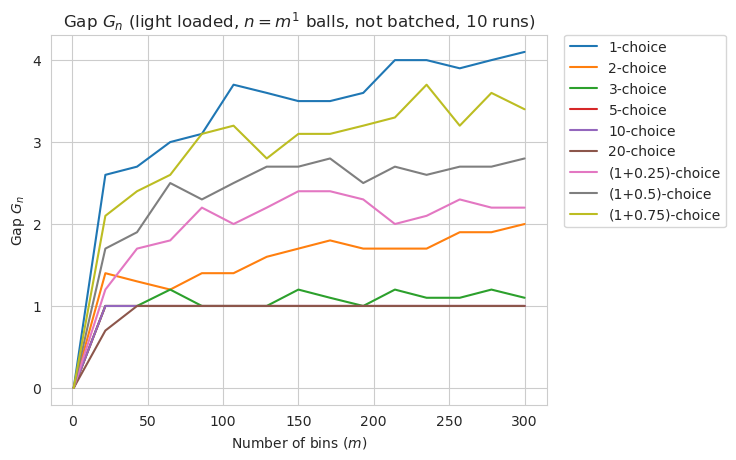

In [4]:
plot_results(scenario='light loaded', n_exp=1, batch_exp=None)

100%|██████████████████████████████████████| 1350/1350 [00:10<00:00, 125.71it/s]


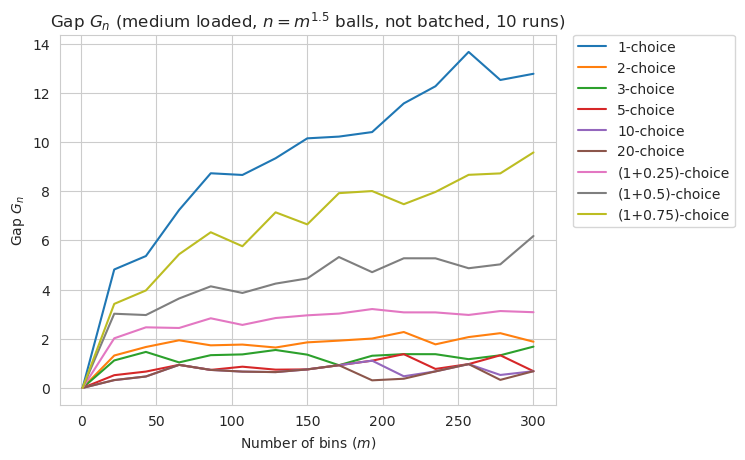

In [5]:
plot_results(scenario='medium loaded', n_exp=1.5, batch_exp=None)

100%|███████████████████████████████████████| 1350/1350 [02:35<00:00,  8.65it/s]


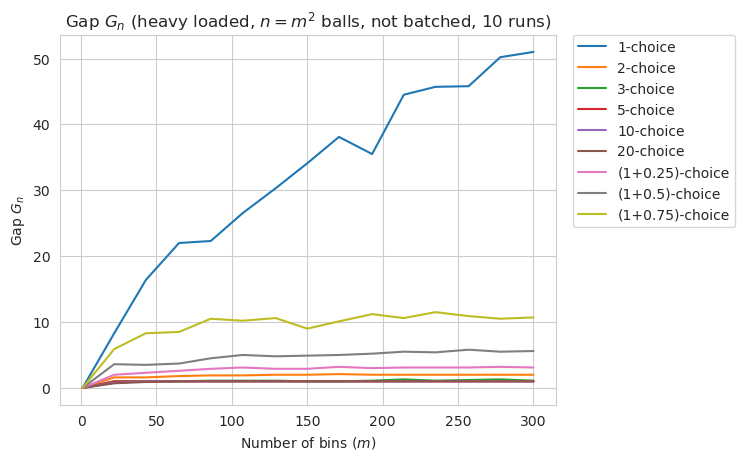

In [6]:
plot_results(scenario='heavy loaded', n_exp=2, batch_exp=None)

100%|██████████████████████████████████████| 1350/1350 [00:01<00:00, 735.14it/s]


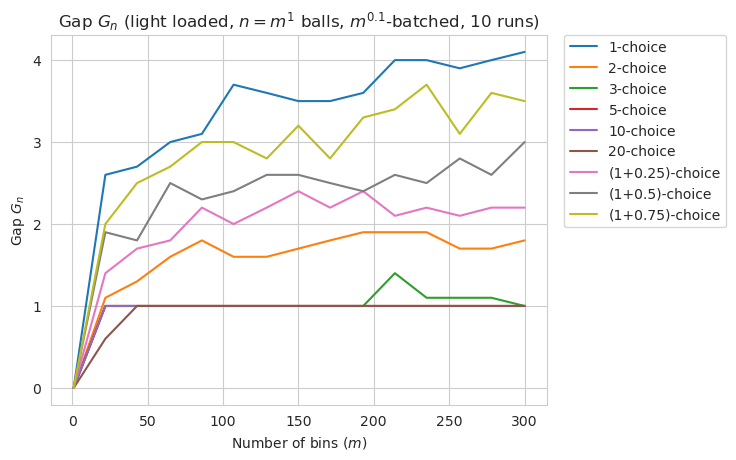

In [7]:
plot_results(scenario='light loaded', n_exp=1, batch_exp=0.1)

100%|█████████████████████████████████████| 1350/1350 [00:00<00:00, 1425.77it/s]


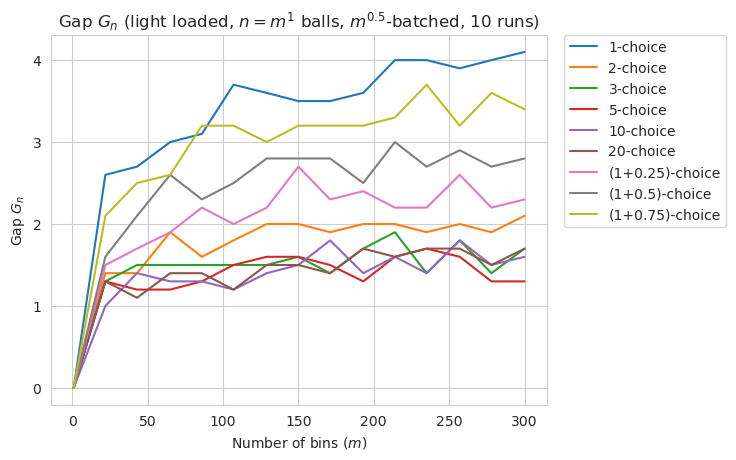

In [8]:
plot_results(scenario='light loaded', n_exp=1, batch_exp=0.5)

100%|█████████████████████████████████████| 1350/1350 [00:00<00:00, 1488.21it/s]


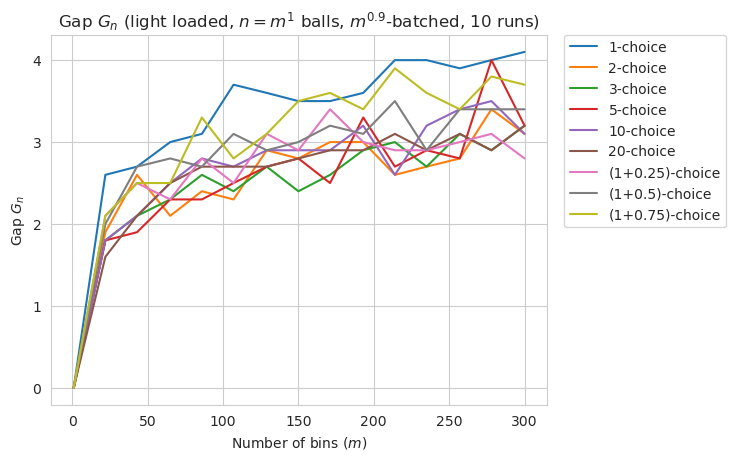

In [9]:
plot_results(scenario='light loaded', n_exp=1, batch_exp=0.9)

100%|███████████████████████████████████████| 1350/1350 [00:23<00:00, 56.31it/s]


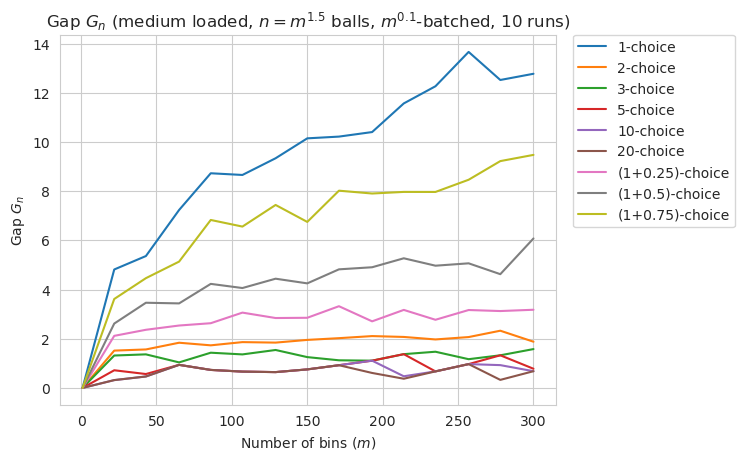

In [10]:
plot_results(scenario='medium loaded', n_exp=1.5, batch_exp=0.1)

100%|██████████████████████████████████████| 1350/1350 [00:11<00:00, 114.30it/s]


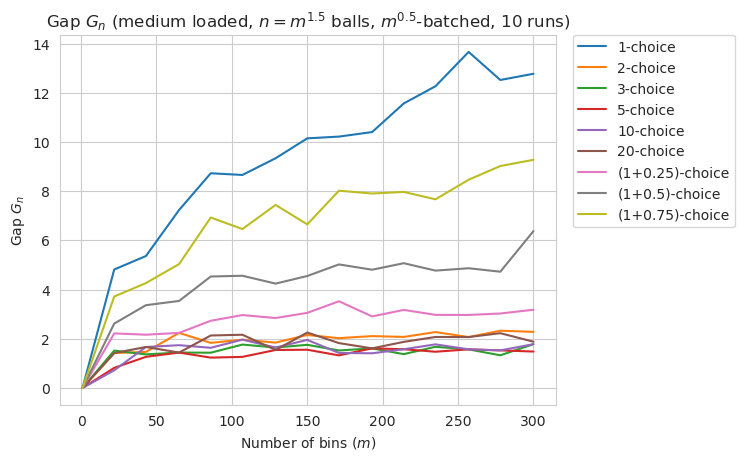

In [11]:
plot_results(scenario='medium loaded', n_exp=1.5, batch_exp=0.5)

100%|██████████████████████████████████████| 1350/1350 [00:10<00:00, 122.86it/s]


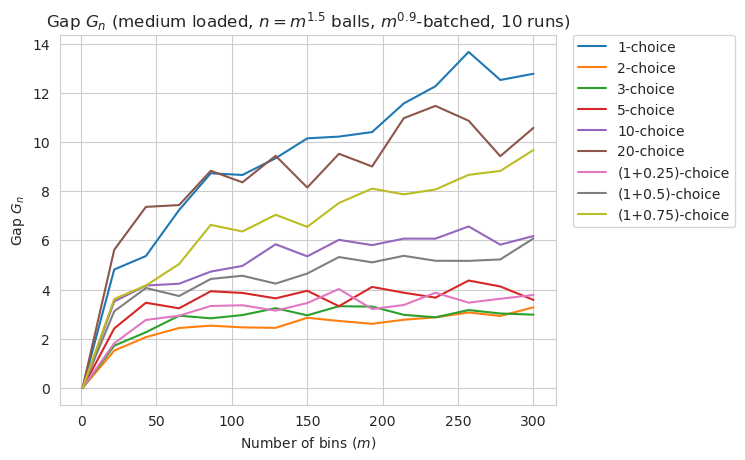

In [12]:
plot_results(scenario='medium loaded', n_exp=1.5, batch_exp=0.9)

100%|███████████████████████████████████████| 1350/1350 [05:49<00:00,  3.87it/s]


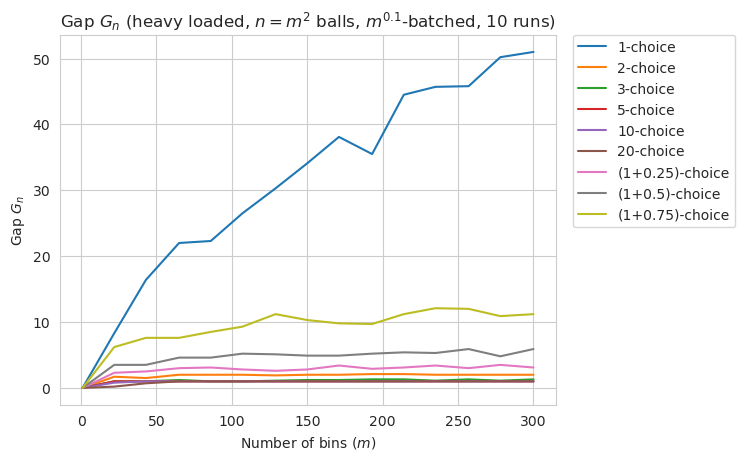

In [13]:
plot_results(scenario='heavy loaded', n_exp=2, batch_exp=0.1)

100%|███████████████████████████████████████| 1350/1350 [02:50<00:00,  7.92it/s]


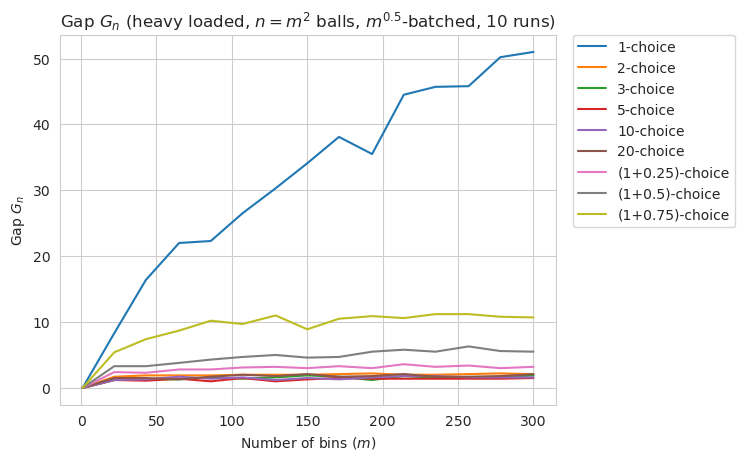

In [14]:
plot_results(scenario='heavy loaded', n_exp=2, batch_exp=0.5)

100%|███████████████████████████████████████| 1350/1350 [02:40<00:00,  8.42it/s]


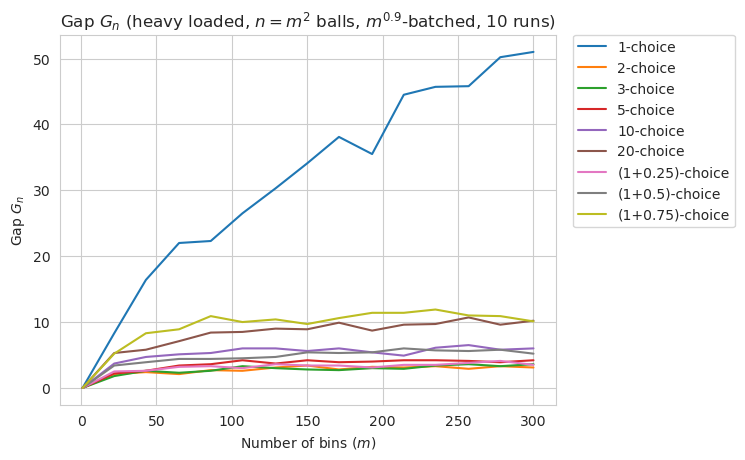

In [15]:
plot_results(scenario='heavy loaded', n_exp=2, batch_exp=0.9)

100%|███████████████████████████████████████| 1350/1350 [02:41<00:00,  8.35it/s]


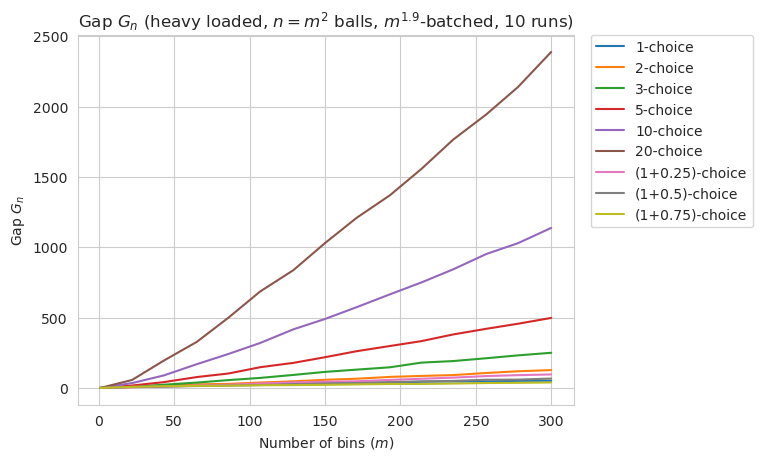

In [16]:
plot_results(scenario='heavy loaded', n_exp=2, batch_exp=1.9)